# MRI Görüntülerinden Beyin Tümörü Sınıflandırması

## Derin Öğrenme (FET312) - Final Proje Kod Dosyası

**Öğrenci:** Burak Şahin  
**Grup:** DevTe213  
**Hedef Model:** DenseNet121 (Densely Connected Networks)  

### Model Stratejisi: Özellik Tekrarı ve Yoğun Bağlantılar
Bu notebook dosyasında, her katmanın kendinden önceki tüm katmanlardan veri aldığı **Dense Connections (Yoğun Bağlantılar)** yapısına sahip **DenseNet121** mimarisi kullanılmıştır. Bu yapı, "Feature Reuse" (Özellik Tekrarı) sayesinde daha az parametre ile yüksek başarı sağlar ve bilgi akışını maksimuma çıkarır.

**Uygulanan Yöntem:**
1.  **Transfer Learning:** ImageNet ağırlıkları ile model başlatılarak, tıbbi görüntülemede kritik olan kenar ve doku algısı hazır alınmıştır.
2.  **Feature Extraction (Dondurma):** Özellik haritalarını birleştiren konvolüsyon blokları dondurulmuş (`requires_grad=False`), böylece eğitim süresi kısaltılmıştır.
3.  **Fine-Tuning:** Modelin sınıflandırıcı (classifier) katmanı, projemizdeki 4 hedef sınıf (Glioma, Meningioma, Pituitary, No Tumor) için özelleştirilerek eğitilmiştir.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import time
import copy
import os
import gc
import json

# Hafiza Temizligi
gc.collect()
torch.cuda.empty_cache()

# Ayarlar
BATCH_SIZE = 16
IMG_SIZE = 224
LEARNING_RATE = 0.001
EPOCHS = 20
RANDOM_SEED = 213

# Seed Sabitleme
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

# Cihaz Secimi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Cihaz: {device}")

Cihaz: cuda


In [2]:
DATA_PATH = r"C:\Users\ArdaOlmez\Desktop\others\projects\python\datasets\brain_tumor_dataset-2\training"

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

try:
    full_dataset = datasets.ImageFolder(DATA_PATH, transform=data_transforms['train'])
    
    total_len = len(full_dataset)
    train_len = int(0.7 * total_len)
    val_len = int(0.15 * total_len)
    test_len = total_len - train_len - val_len

    train_data, val_data, test_data = torch.utils.data.random_split(
        full_dataset, [train_len, val_len, test_len],
        generator=torch.Generator().manual_seed(RANDOM_SEED)
    )

    dataloaders = {
        'train': DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0),
        'val': DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=0),
        'test': DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    }
    
    print("-" * 30)
    print("VERI SETI BILGILERI")
    print("-" * 30)
    print(f"Toplam Goruntu Sayisi: {total_len}")
    print(f"Egitim Seti (Train)  : {len(train_data)}")
    print(f"Dogrulama Seti (Val) : {len(val_data)}")
    print(f"Test Seti (Test)     : {len(test_data)}")
    print(f"Sinif Isimleri       : {full_dataset.classes}")
    print("-" * 30)

except Exception as e:
    print(f"HATA: {e}")

------------------------------
VERI SETI BILGILERI
------------------------------
Toplam Goruntu Sayisi: 5712
Egitim Seti (Train)  : 3998
Dogrulama Seti (Val) : 856
Test Seti (Test)     : 858
Sinif Isimleri       : ['glioma', 'meningioma', 'notumor', 'pituitary']
------------------------------


In [3]:
print("Model hazirlaniyor...")
model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

# Katmanlari Dondur
for param in model.parameters():
    param.requires_grad = False

# DenseNet'te siniflandirma blogu 'classifier' ismindedir
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 4)

model = model.to(device)
print("Model GPU uzerine alindi.")

Model hazirlaniyor...
Model GPU uzerine alindi.


In [4]:
# Sadece classifier katmanini egitecegiz
optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

since = time.time() # Baslangic zamani
best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

# Sonuclari tutacagimiz sozluk
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print(f"Egitim Basliyor... (20 Epoch)")

for epoch in range(EPOCHS):
    # Her epoch basinda hafiza temizligi
    gc.collect()
    torch.cuda.empty_cache()
    
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
        
        history[f'{phase}_loss'].append(epoch_loss)
        history[f'{phase}_acc'].append(epoch_acc.item())

        if phase == 'val':
            print(f'Epoch {epoch+1}/{EPOCHS} | Val Acc: {epoch_acc:.4f}')
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

# Egitim suresini hesapla
time_elapsed = time.time() - since
print("-" * 30)
print(f'Egitim Tamamlandi. Gecen Sure: {time_elapsed // 60:.0f} dakika {time_elapsed % 60:.0f} saniye')
print(f'En Iyi Validasyon Basarisi: {best_acc:.4f}')

print("-" * 30)
print("Veriler kaydediliyor...")

# 1. En iyi modeli kaydet (.pth dosyasi)
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), 'Burak_DenseNet121_Final.pth')

# 2. Grafik verilerini kaydet (.json dosyasi)
with open('burak_history.json', 'w') as f:
    json.dump(history, f)

print("ISLEM TAMAMLANDI.")
print("Model: Burak_DenseNet121_Final.pth olarak kaydedildi.")
print("Gecmis: burak_history.json olarak kaydedildi.")

Egitim Basliyor... (20 Epoch)
Epoch 1/20 | Val Acc: 0.8773
Epoch 2/20 | Val Acc: 0.8960
Epoch 3/20 | Val Acc: 0.8960
Epoch 4/20 | Val Acc: 0.8972
Epoch 5/20 | Val Acc: 0.9124
Epoch 6/20 | Val Acc: 0.8960
Epoch 7/20 | Val Acc: 0.9252
Epoch 8/20 | Val Acc: 0.9054
Epoch 9/20 | Val Acc: 0.9206
Epoch 10/20 | Val Acc: 0.9182
Epoch 11/20 | Val Acc: 0.9206
Epoch 12/20 | Val Acc: 0.9276
Epoch 13/20 | Val Acc: 0.9147
Epoch 14/20 | Val Acc: 0.9287
Epoch 15/20 | Val Acc: 0.9252
Epoch 16/20 | Val Acc: 0.9089
Epoch 17/20 | Val Acc: 0.9054
Epoch 18/20 | Val Acc: 0.9194
Epoch 19/20 | Val Acc: 0.9229
Epoch 20/20 | Val Acc: 0.9241
------------------------------
Egitim Tamamlandi. Gecen Sure: 12 dakika 37 saniye
En Iyi Validasyon Basarisi: 0.9287
------------------------------
Veriler kaydediliyor...
ISLEM TAMAMLANDI.
Model: Burak_DenseNet121_Final.pth olarak kaydedildi.
Gecmis: burak_history.json olarak kaydedildi.


Grafik verileri dosyadan yuklendi.


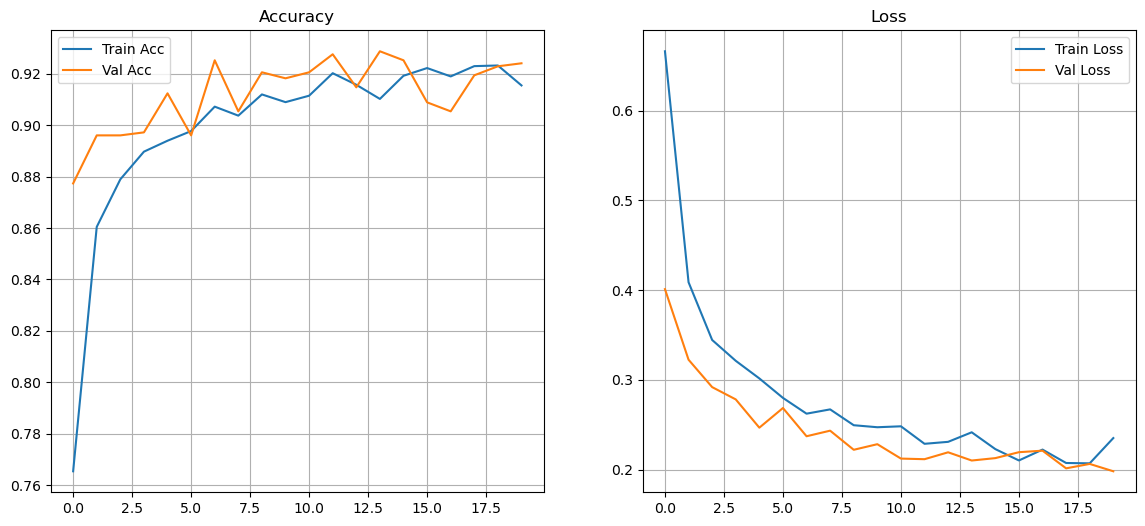

In [1]:
import json
import matplotlib.pyplot as plt

# JSON dosyasindan verileri oku
try:
    with open('burak_history.json', 'r') as f:
        history = json.load(f)
    
    print("Grafik verileri dosyadan yuklendi.")
    
    plt.figure(figsize=(14, 6))
    
    # Accuracy Grafigi
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Loss Grafigi
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.show()

except FileNotFoundError:
    print("HATA: burak_history.json dosyasi bulunamadi.")

Test islemi hazirlaniyor...
Model agirliklari basariyla yuklendi.
Test tahminleri hesaplaniyor...

SINIFLANDIRMA RAPORU
              precision    recall  f1-score   support

      glioma     0.9556    0.8958    0.9247       192
  meningioma     0.8429    0.8474    0.8451       190
     notumor     0.9579    0.9690    0.9634       258
   pituitary     0.9204    0.9541    0.9369       218

    accuracy                         0.9219       858
   macro avg     0.9192    0.9166    0.9176       858
weighted avg     0.9224    0.9219    0.9218       858



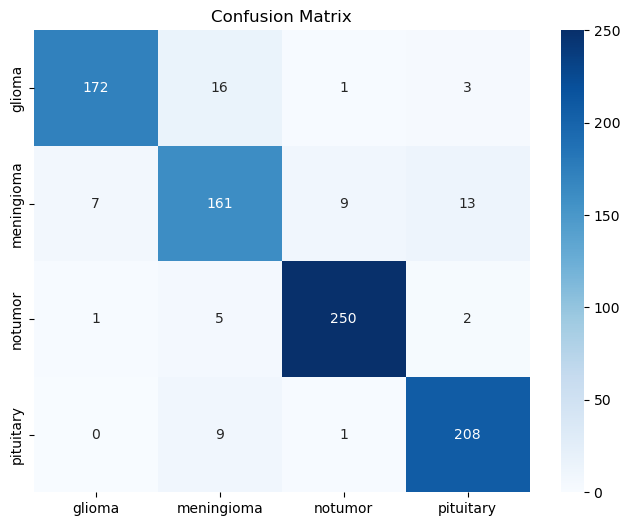

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc

# Hafiza Temizligi
gc.collect()
torch.cuda.empty_cache()

# Ayarlar
DATA_PATH = r"C:\Users\ArdaOlmez\Desktop\others\projects\python\datasets\brain_tumor_dataset-2\training"
BATCH_SIZE = 16
IMG_SIZE = 224
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Test islemi hazirlaniyor...")

# Veri Setini Tekrar Tanimla (Sadece Test Icin)
data_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(DATA_PATH, transform=data_transforms)
total_len = len(full_dataset)
train_len = int(0.7 * total_len)
val_len = int(0.15 * total_len)
test_len = total_len - train_len - val_len

# Seed ayni oldugu icin split ayni olacaktir
torch.manual_seed(213)
_, _, test_data = torch.utils.data.random_split(
    full_dataset, [train_len, val_len, test_len],
    generator=torch.Generator().manual_seed(213)
)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# Modeli Kur
model = models.densenet121(weights=None)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 4)
model = model.to(device)

# Agirliklari Dosyadan Yukle
try:
    model.load_state_dict(torch.load('Burak_DenseNet121_Final.pth', map_location=device))
    print("Model agirliklari basariyla yuklendi.")
    
    model.eval()
    all_preds = []
    all_labels = []
    
    print("Test tahminleri hesaplaniyor...")
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Rapor
    print("\nSINIFLANDIRMA RAPORU")
    print(classification_report(all_labels, all_preds, target_names=full_dataset.classes, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
    plt.title('Confusion Matrix')
    plt.show()

except FileNotFoundError:
    print("HATA: Burak_DenseNet121_Final.pth dosyasi bulunamadi.")